In [1]:
import pandas as pd
import numpy as np
import os
from acquire import get_hwyrail, get_equiprail
from prepare import prep_hwy_df
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from scipy import stats
from sklearn.model_selection import train_test_split

from datetime import date, datetime
from explore import train_validate_test_split, freq_table

In [2]:
df = get_hwyrail()

In [3]:
df.shape

(18995, 104)

In [4]:
df = prep_hwy_df(df)

In [5]:
df.shape

(12181, 48)

In [6]:
def get_season(row):
    if row['date'].month >= 3 and row['date'].month <= 5:
        return 'Spring'
    elif row['date'].month >= 6 and row['date'].month <= 8:
        return 'Summer'
    elif row['date'].month >= 9 and row['date'].month <= 11:
        return 'Fall'
    else:
        return 'Winter'

df['season'] = df.apply(get_season, axis=1)

In [8]:
df.season.value_counts()

Fall      3176
Winter    3116
Summer    3093
Spring    2796
Name: season, dtype: int64

In [9]:
df.head()

,railroad_company,station,county,state,region,city,vehicle_speed,vehicle_type,vehicle_direction,position,...,train_occupants,user_killed,user_injured,rail_killed,rail_injured,train_pass_killed,train_pass_injured,road_condtions,date,season
incdtno,,,,,,,,,,,,,,,,,,,,,
0312RS009,UP,WOODBRIDGE,SAN JOAQUIN,6,7,LODI,0.0,A,4,2,...,3,0,0,0,0,0,0,B,2012-03-16 09:15:00,Spring
0312RS025,UP,ACAMPO,SAN JOAQUIN,6,7,,0.0,A,4,2,...,2,0,0,0,0,0,0,A,2012-03-30 21:35:00,Spring
CA1012201,BNSF,LOS NIETOS,LOS ANGELES,6,7,SANTA FE SPRINGS,0.0,A,1,2,...,3,0,0,0,0,0,0,A,2012-10-07 20:25:00,Fall
CA0712201,BNSF,FRESNO,FRESNO,6,7,FRESNO,0.0,A,1,2,...,2,0,1,0,0,0,0,A,2012-07-28 20:55:00,Summer
0612RS011,UP,BAKERSFIELD,KERN,6,7,,50.0,C,4,3,...,3,0,0,0,0,0,0,A,2012-06-18 15:58:00,Summer


In [10]:
df.state.value_counts()

48    1631
13     751
18     727
6      698
1      583
17     518
39     516
22     492
45     361
37     359
21     355
42     352
12     344
29     343
47     342
5      307
40     293
20     277
51     275
31     274
28     216
53     199
27     182
8      165
26     157
4      152
54     150
19     138
24     121
36     119
38     113
16     108
55      89
41      79
35      72
30      62
46      54
34      51
49      38
56      37
10      29
25      16
32      15
50       8
9        5
23       4
33       2
11       2
Name: state, dtype: int64

## Takeaway

 - states like Texas, Georgia, Indiana, Alabama, Ohio rank highest in hwy rail accidents while states in the NE like Vermont, Conneticut & DC are at the very bottom.
     - is this because people in NE are more accustomed to trains and people in middle america don't see them as often?
     - Need to look at state populations and compare average accident (i.e., vermont could have 5 people but 2 accidents while Texas could have 28 million people and 1,000 accidents. need to look at the numbers and compare

Initial hypothesis

 - Rail accidents are more prevelant in southern and middle america
     

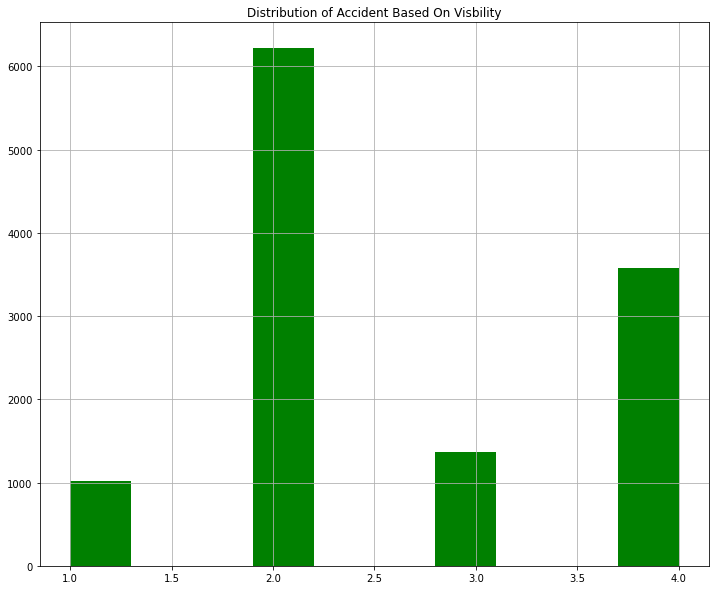

In [11]:
df['visibility'].hist(color='green', figsize=(12, 10))

plt.title('Distribution of Accident Based On Visbility')
plt.show()

----
## Takeaway

Majority of accident happen the day followed by night...not many at dawn or dusk

In [12]:
df.weather = df.weather.astype(int)

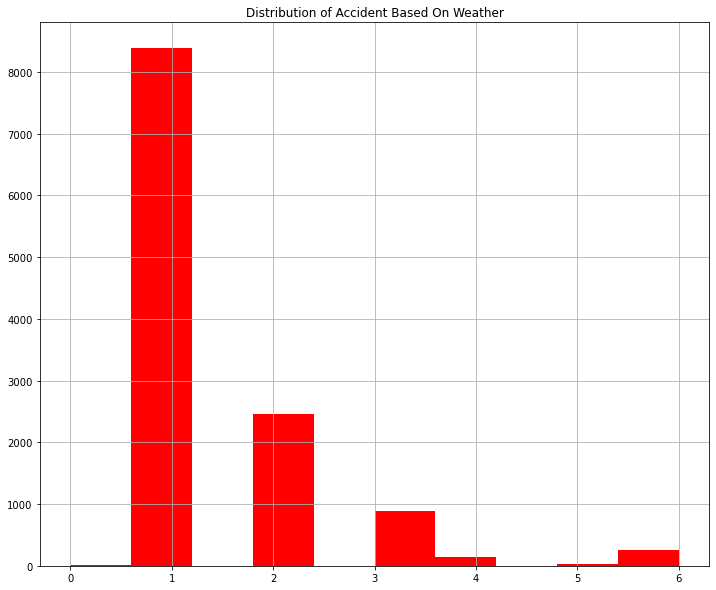

In [13]:
df['weather'].hist(color='red', figsize=(12, 10))

plt.title('Distribution of Accident Based On Weather')
plt.show()

-----

## Takeaway

- Clear weather followed by cloudy skies are when the majority of accidents take place

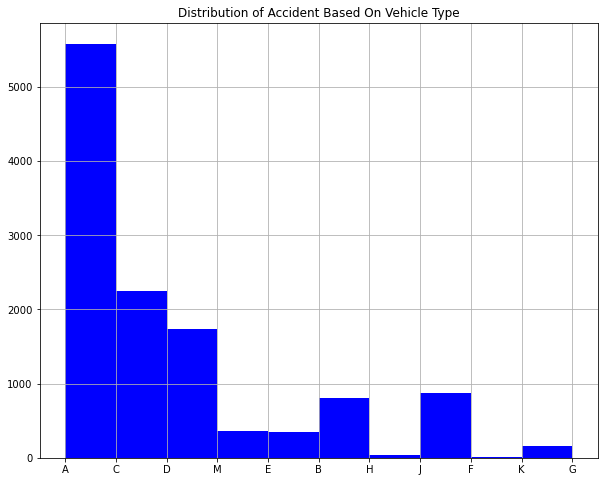

In [14]:
df['vehicle_type'].hist(color='blue', figsize=(10,8))

plt.title('Distribution of Accident Based On Vehicle Type')
plt.show()

In [15]:
df.vehicle_type.value_counts()

A    5585
C    2248
D    1731
J     878
B     804
M     366
E     352
K     156
H      39
F      17
G       5
Name: vehicle_type, dtype: int64


-----
## Takeway
 
 - most accidents are involved with auto(cars) followed by tractor trailers, then pick up trucks. School buses were at the very bottom which was good to see although there were still 5 instances. 

-----------

## OUTLIERS

-------

<AxesSubplot:xlabel='front_engines'>

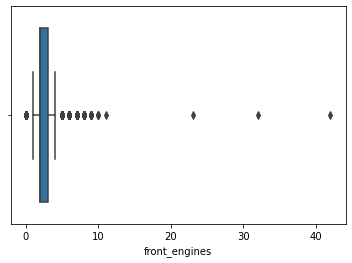

In [16]:
sns.boxplot(data = df, x = 'front_engines')

 - Have some crazy outliers with 3 accidents having over 20 engines

<AxesSubplot:xlabel='railcar_quantity'>

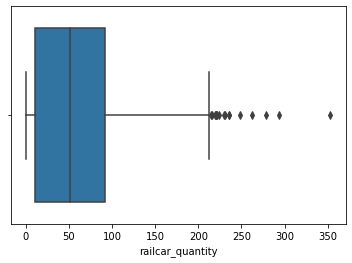

In [17]:
sns.boxplot(data=df, x = 'railcar_quantity')

- majority of railcar quanity is between 0-100 cars but there are some outliers above 200 with one coming in at a whopping 350 cars

<AxesSubplot:xlabel='train_speed'>

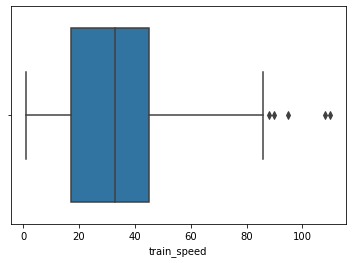

In [18]:
sns.boxplot(data = df, x = 'train_speed')

- train speed outliers above 80 mph, with 2 over 100 mph

<AxesSubplot:xlabel='temp'>

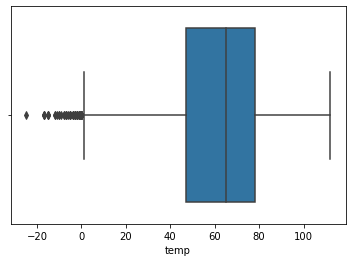

In [19]:
sns.boxplot(data = df, x = 'temp')

- outliers exist for accidents where temp was below 0 degrees with 1 occuring where temp was greater than -20

In [20]:
df.position.value_counts()

3    5578
2    2202
3    1659
1    1589
2     710
1     430
5       6
5       3
4       3
4       1
Name: position, dtype: int64

## Takeaways

- a majority of people involved in accidents were either moving across the crossing when hit or were stopped. A small amount (4 & 5) were either blocked or trapped inside the crossing 

In [21]:
df.road_condtions.value_counts()

A    10133
B     1268
C      430
E      232
D      113
F        5
Name: road_condtions, dtype: int64

## Takeaways

- conditions were dry(A) for a majority of the incidents followed by wet (B) and then snow/slush(C)

In [22]:
df.view_obstruction.value_counts()

8    11794
5       72
3       70
1       69
7       51
6       50
2       46
4       29
Name: view_obstruction, dtype: int64

## Takeaways
- Majority of accidents had zero obstruction while vegetation was next with less than 80 incidents. 

In [23]:
df.motorist_action.value_counts()

3    3768
4    2996
1    1508
5    1485
2     600
3     428
7     388
4     308
5     199
1     195
8     114
2      93
7      58
6      23
8      15
0       2
6       1
Name: motorist_action, dtype: int64

## Takeaways

- Most motorists did not stop for the train (#3) and were hit or they stopped in the crossing(#4) and were hit. After that, people went around gates (#3). Lower on the list were people who went thru the gates(#7) and then those who attempted or committed suicide (#8)

In [24]:
cat_var = ['railroad_company', 'station', 'weather', 'train_type', 'track_type']

---------------------------

## Train Data/Bi-Variate/Multi-Variate Exploration

---------------------

In [25]:
train, validate, test = train_validate_test_split(df, 'railroad_company', seed=123)

In [26]:
train.shape, validate.shape, test.shape

((6820, 49), (2924, 49), (2437, 49))

In [27]:
train.groupby('railroad_company').railcar_quantity.median()

railroad_company
ATK      7.0
BNSF    67.0
CSX     53.5
KCS     59.0
NS      43.0
UP      73.0
Name: railcar_quantity, dtype: float64

In [28]:
train.groupby('railroad_company').train_speed.median()

railroad_company
ATK     65.0
BNSF    35.0
CSX     29.0
KCS     30.0
NS      28.0
UP      35.0
Name: train_speed, dtype: float64

<AxesSubplot:xlabel='weather', ylabel='Count'>

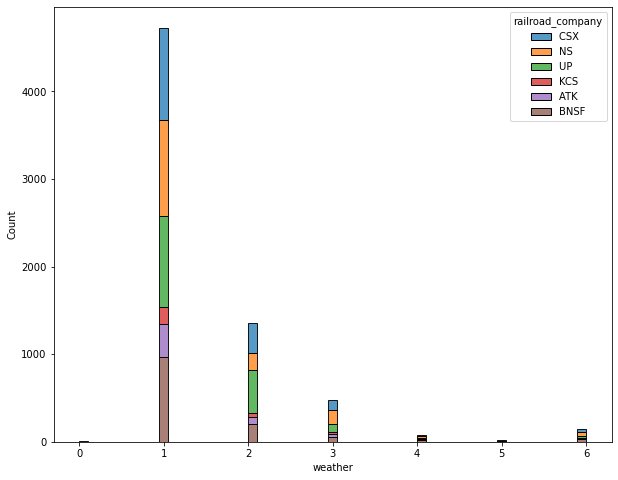

In [29]:
plt.figure(figsize=(10,8))
sns.histplot(data=train, x="weather", hue = "railroad_company", multiple="stack")

In [30]:
train.groupby(['railroad_company', 'weather']).vehicle_damage.max()

railroad_company  weather
ATK               1           150000.0
                  2            60000.0
                  3            20000.0
                  4            22000.0
                  5             5000.0
                  6            15000.0
BNSF              1           100000.0
                  2            80000.0
                  3            10000.0
                  4             5000.0
                  5             5000.0
                  6            20000.0
CSX               0             7800.0
                  1           500000.0
                  2           276000.0
                  3            27500.0
                  4            15500.0
                  5            27500.0
                  6            20500.0
KCS               1            75000.0
                  2           120000.0
                  3            18995.0
                  4             4500.0
NS                1          1000000.0
                  2           100000.0

In [32]:
train.groupby(['railroad_company', 'season']).vehicle_damage.median()

railroad_company  season
ATK               Fall      7000.0
                  Spring    5000.0
                  Summer    4000.0
                  Winter    6000.0
BNSF              Fall      2000.0
                  Spring    2000.0
                  Summer    2000.0
                  Winter    2000.0
CSX               Fall      6500.0
                  Spring    6500.0
                  Summer    6500.0
                  Winter    6500.0
KCS               Fall      5000.0
                  Spring    4000.0
                  Summer    6000.0
                  Winter    7500.0
NS                Fall      3000.0
                  Spring    3000.0
                  Summer    3000.0
                  Winter    3000.0
UP                Fall      5000.0
                  Spring    5000.0
                  Summer    5000.0
                  Winter    5000.0
Name: vehicle_damage, dtype: float64

In [33]:
train.groupby(['railroad_company', 'season']).vehicle_damage.max()

railroad_company  season
ATK               Fall       100000.0
                  Spring     150000.0
                  Summer     100000.0
                  Winter      60000.0
BNSF              Fall        50000.0
                  Spring     100000.0
                  Summer     100000.0
                  Winter      20000.0
CSX               Fall        75000.0
                  Spring     500000.0
                  Summer     276000.0
                  Winter     500000.0
KCS               Fall        25000.0
                  Spring     120000.0
                  Summer      75000.0
                  Winter      70000.0
NS                Fall       312000.0
                  Spring     100000.0
                  Summer    1000000.0
                  Winter      60000.0
UP                Fall       750000.0
                  Spring     250000.0
                  Summer     300000.0
                  Winter     200000.0
Name: vehicle_damage, dtype: float64